In [1]:
import numpy as np
from numpy.random import choice
import pickle
from tqdm.auto import tqdm
import sys
import time
import matplotlib.pyplot as plt

from routines_aux import gf2RowRed

def lst_gen(lst):
    for item in lst:
        yield item  

In [2]:
# load all elements of C2
infile = open('allGates', 'rb')
allGates = pickle.load(infile)
infile.close()

# load dictionary from index to decomposition
infile = open('dictClif', 'rb')
dictClif = pickle.load(infile)
infile.close()

# for brute force unitary trace verification
from routines_genclif import *


allGates_phaseless = np.empty((len(allGates), 4, 4), dtype='int')
for gate_ind in range(allGates.shape[0]):
    allGates_phaseless[gate_ind] = allGates[gate_ind, [8,4,2,1], :-1].T

In [3]:
def twoQubitClif(tab, gate, a, b):
    """
    PHASELESS gate evolution
    this varies from the usual twoQubitClif for tableaus, here each COLUMN is a stabiliser (Pauli string)
    """
    n = np.shape(tab)[1] // 2
    matches = tab[n+b,:] + 2*tab[n+a,:] + 4*tab[b,:] + 8*tab[a,:]
    tab[a,:] = gate[matches,0] # xa
    tab[b,:] = gate[matches,1] # xb
    tab[n+a,:] = gate[matches,2] # za
    tab[n+b,:] = gate[matches,3] # zb
    
def twoQubitClif_ps(ps, gate, a, b):
    """
    PHASEFUL gate evolution
    acts on 1D array pauli string ps, where the last position indexes the phsae 
    """
    L = len(ps) // 2
    match = ps[L+b] + 2*ps[L+a] + 4*ps[b] + 8*ps[a]
    ps[a] = gate[match,0] # xa
    ps[b] = gate[match,1] # xb
    ps[L+a] = gate[match,2] # za
    ps[L+b] = gate[match,3] # zb
    ps[2*L] = (ps[2*L] + gate[match,4]) % 2 # phase

In [4]:
def pbcBasisChange(L):
    permute = np.zeros((2**L,2**L),dtype='int8')
    for i in range(len(permute)-1): permute[2*i%(2**L-1),i] = 1
    permute[2**L-1,2**L-1] = 1
    # print(np.array_equal(np.linalg.inv(permute), permute.T))
    return permute

def unitaryGate(floquet_array, timesteps, permute):
    
    U1 = decompToUni(dictClif[floquet_array[0]])
    for ind in range(1,len(floquet_array)//2):
        U1 = np.kron(U1, decompToUni(dictClif[floquet_array[ind]]))

    U2 = decompToUni(dictClif[floquet_array[len(floquet_array)//2]])
    for ind in range(len(floquet_array)//2+1,len(floquet_array)):
        U2 = np.kron(U2, decompToUni(dictClif[floquet_array[ind]]))
    
    U2 = permute.T @ U2 @ permute

    U = U2 @ U1
    U = np.linalg.matrix_power(U, timesteps)
    
    return U

In [5]:
def exp_sff(L, reps, max_t, directory, name_ext):
    circuits = choice(np.arange(576,len(allGates)), (L,reps))
    n_evecs_t = np.zeros((max_t,reps))
    allphase1 = np.full((max_t,reps), True)
    
    #-------------------------------------------------------------
    
    permute = pbcBasisChange(L)
    
    #-------------------------------------------------------------

    for circuit_ind in tqdm(range(reps)):
        floquet_array = circuits[:,circuit_ind]
        
        for timesteps in range(max_t):
            
            pauli_strings = np.identity(2*L, dtype='int8')
        
            for t in range(timesteps):
                floquet = lst_gen(floquet_array)
                for i in range(0, L ,2):
                    gate = allGates[next(floquet)]
                    twoQubitClif(pauli_strings, gate, i, i+1)
                for i in range(1, L+1, 2):
                    gate = allGates[next(floquet)]
                    twoQubitClif(pauli_strings, gate, i, (i+1)%L)

            gate = pauli_strings

            eig1 = (gate - np.eye(2*L, dtype='int8')) % 2
            system = np.vstack((eig1, np.identity(2*L, dtype='int8')))
            system_solved = gf2RowRed(system.T.copy()).T
            

            n_evecs = 0
            eigvecs = []
            for col in range(2*L):
                if np.sum(system_solved[:2*L,col]) == 0:
                    n_evecs += 1
                    eigvec = system_solved[2*L:,col]
                    eigvecs.append(eigvec)
                    if not np.array_equal((gate @ eigvec) % 2, eigvec):
                        print(col, eigvec, (gate @ eigvec) % 2)
                        raise Exception()
            n_evecs_t[timesteps,circuit_ind] = n_evecs

            for eigvec in eigvecs:
                ps = np.hstack((eigvec, [0]))

                for t in range(timesteps):
                    floquet = lst_gen(floquet_array)
                    for i in range(0, L ,2):
                        gate = allGates[next(floquet)]
                        twoQubitClif_ps(ps, gate, i, i+1)
                    for i in range(1, L+1, 2):
                        gate = allGates[next(floquet)]
                        twoQubitClif_ps(ps, gate, i, (i+1)%L)

                if (ps[-1] != 0):
                    allphase1[timesteps,circuit_ind] = False
                    break
            
            #-------------------------------------------------------------
            
            U = unitaryGate(floquet_array, timesteps, permute)

            sff_brute = np.round(np.trace(U.H) * np.trace(U),3)
            
            if sff_brute != 2**len(eigvecs) * allphase1[timesteps, circuit_ind]:
                
                print(floquet_array)
                outfile = open('temp_floquet', 'wb')
                pickle.dump(floquet_array, outfile)
                outfile.close()
                
                print('timesteps:', timesteps)
                print('sff_brute:', sff_brute)
                print('sff_gf2:', 2**n_evecs * allphase1[timesteps, circuit_ind])
                print('len(eigvecs):', len(eigvecs))
                for eigvec in eigvecs:
                    print(eigvec)
                
                outfile = open('temp_ps', 'wb')
                pickle.dump(pauli_strings, outfile)
                outfile.close()
                
                outfile = open('temp_system', 'wb')
                pickle.dump(system, outfile)
                outfile.close()
                
                outfile = open('temp_syssolved', 'wb')
                pickle.dump(system_solved, outfile)
                outfile.close()
                
                raise Exception()
            #-------------------------------------------------------------

#     outfile = open(directory + '/L' + str(L) + '_evol' + str(max_t//L) + '_' + name_ext, 'wb')
#     pickle.dump(np.stack((n_evecs_t, allphase1)), outfile)
#     outfile.close()

    return n_evecs_t, allphase1, circuits

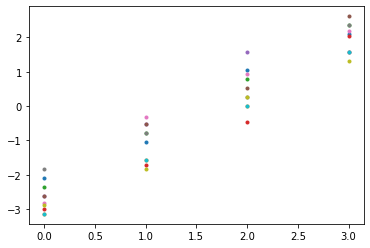

In [33]:
for i in range(10):
    ind = choice(np.arange(576,len(allGates)))
    U = decompToUni(dictClif[ind])
    # print(np.round(U,3))

    eigvals = np.linalg.eigvals(U)
    energy = 1j*np.log(eigvals)
    energy = np.sort(np.real(energy))

    plt.plot(energy, '.')

In [20]:
directory = ''
L = 8
reps = 10
max_t = L
name_ext = ''

n_evecs_t, allphase1, circuits = exp_sff(L=L, reps=reps, max_t=max_t, directory=directory, name_ext=name_ext)
print(circuits)

# this is an interesting circuit
# [9802 9503 2698 4928 6737 7337  903 6622]


[[11217  4123 11134  3743  7119  5759  7077  4614  6252 11227]
 [ 6975  3145  9783  1338 10114  6324  5639  9177  9460  5296]
 [ 3709  1414 10136  5785  8600  4559 10710  1299  6824  6076]
 [11055  8927  5495  6297  3466  7719 10411   698  4320  8513]
 [ 4737  5144  8514  2545  1535  1861  4053  5182  6816  2659]
 [11466  4748  5428  5792  9767  6656  4989  8740  4574   969]
 [11018  4852  7755  3803  6715  6169 10757  1886  4016  6607]
 [ 5360  6829  5328  9949  8239  7464 11341  5118  3451 10015]]


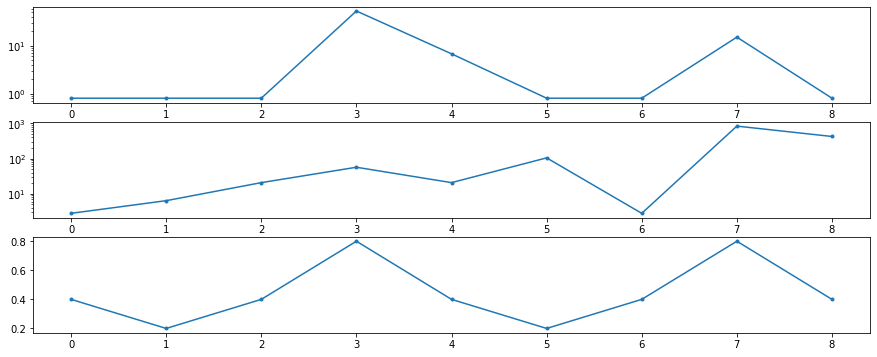

In [113]:
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.semilogy(np.mean((2**(n_evecs_t) * allphase1)[1:],axis=1), '.-')
plt.subplot(3,1,2)
plt.semilogy(np.mean((2**(n_evecs_t))[1:],axis=1), '.-')
plt.subplot(3,1,3)
plt.plot(np.mean(allphase1[1:],axis=1), '.-')

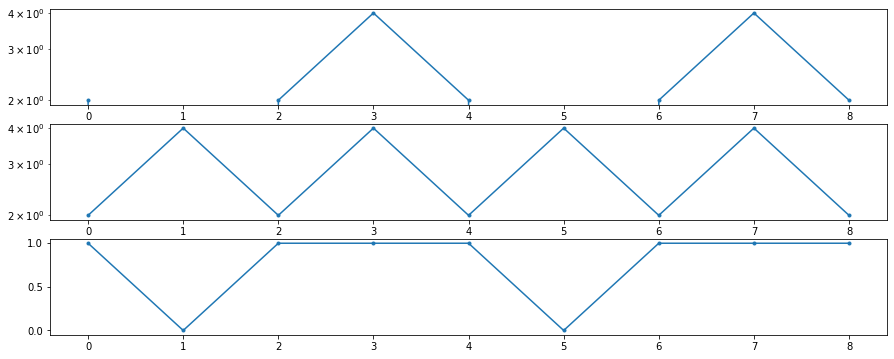

In [119]:
circuit_ind = 4
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.semilogy((2**(n_evecs_t) * allphase1)[1:, circuit_ind], '.-')
plt.subplot(3,1,2)
plt.semilogy((2**(n_evecs_t))[1:, circuit_ind], '.-')
plt.subplot(3,1,3)
plt.plot(allphase1[1:, circuit_ind], '.-')

# many circuits
### threefold energy degenercy -> r=nan 
### exactly twofold energy degeneracy -> r=0
### triplet of energy levels are separated by two equal gaps, the r-ratio is 1

# view energies

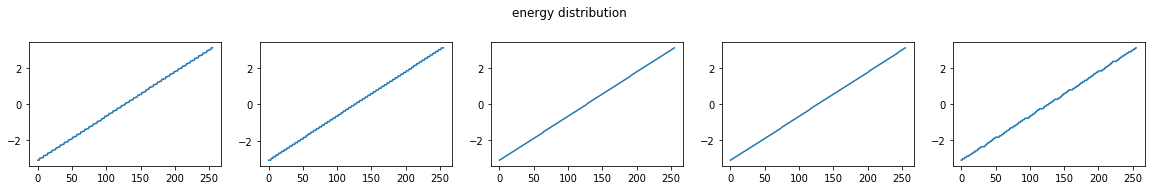

In [7]:
# plot energies with dummy index x

f1 = plt.figure(figsize=(20,5))
f1.suptitle('energy distribution')

rss = np.empty((2**L-2,0))

for circuit_ind in tqdm(range(reps)):
    
    floquet_array = np.ndarray.flatten(circuits[:,circuit_ind])
    uGate = unitaryGate(floquet_array=floquet_array, timesteps=1, permute=pbcBasisChange(L))

    eigvals = np.linalg.eigvals(uGate)
    energy = 1j*np.log(eigvals)
    energy = np.sort(np.real(energy))
    
    #--------
    energy = np.round(energy,10)
    #--------
    
    ax = f1.add_subplot(2,5,circuit_ind+1)
    plt.plot(energy)
    
    #ax = f1.add_subplot(10,1,circuit_ind+1)
    #energy_unique, energy_unique_counts = np.unique(np.round(energy,10), return_counts=True)
    #ax.bar(x=energy_unique, height=energy_unique_counts, width=np.min(np.diff(energy_unique))/3)
    
    #ax = f1.add_subplot(10,1,circuit_ind+1)
    #energy_unique, energy_unique_counts = np.unique(np.round(energy,5), return_counts=True)
    #ax.bar(x=energy_unique, height=energy_unique_counts, width=0.01)
    

/Users/Shiye/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


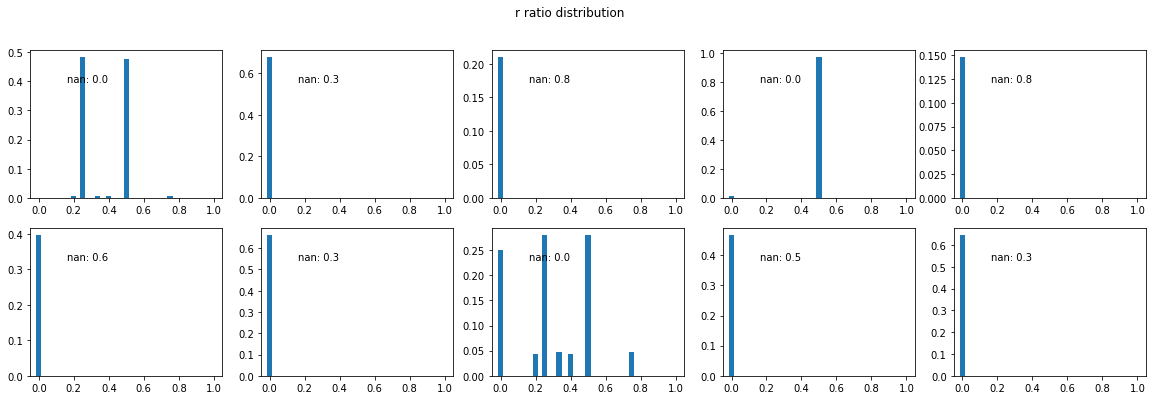

In [21]:
# f1 = plt.figure(figsize=(20,20))
# f1.suptitle('energy distribution')

f2 = plt.figure(figsize=(20,6))
f2.suptitle('r ratio distribution')

rss = np.empty((2**L-2,0))

for circuit_ind in tqdm(range(reps)):
    
    floquet_array = np.ndarray.flatten(circuits[:,circuit_ind])
    uGate = unitaryGate(floquet_array=floquet_array, timesteps=1, permute=pbcBasisChange(L))

    eigvals = np.linalg.eigvals(uGate)
    energy = 1j*np.log(eigvals)
    energy = np.sort(np.real(energy))
    
    #--------
    energy = np.round(energy,10)
    #--------
    
    delta1 = np.diff(energy[:-1])
    delta2 = np.diff(energy[1:])
    numerator = np.min((delta1, delta2),axis=0)
    denominator = np.max((delta1, delta2),axis=0)
    rs = numerator / denominator
    nanvals = np.count_nonzero(denominator==0)

    rs = np.round(rs,10)
    rss = np.hstack((rss, np.reshape(rs,(len(rs), 1))))
    
    ax = f2.add_subplot(2,5,circuit_ind+1)
    rs_unique, rs_unique_counts = np.unique(np.round(rs,6), return_counts=True)
    ax.bar(x=rs_unique, height=rs_unique_counts/len(energy), width=0.03)
    ax.set_xlim([-0.05, 1.05])
    ax.text(0.3, 0.8, 'nan: ' + str(np.round(nanvals/len(energy),1)), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

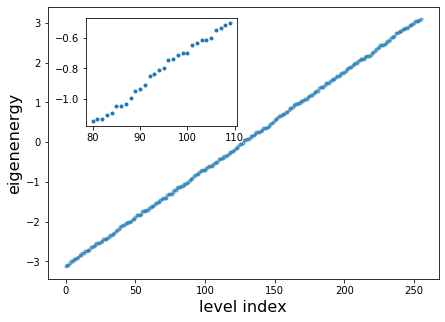

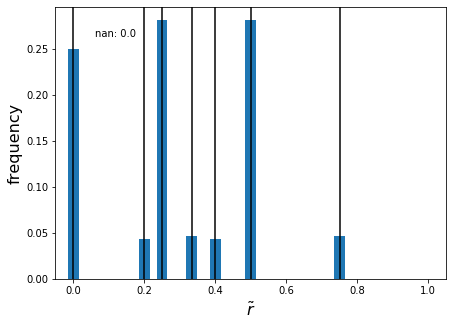

In [28]:
circuit_ind = 7
    
floquet_array = np.ndarray.flatten(circuits[:,circuit_ind])
uGate = unitaryGate(floquet_array=floquet_array, timesteps=1, permute=pbcBasisChange(L))

eigvals = np.linalg.eigvals(uGate)
energy = 1j*np.log(eigvals)
energy = np.sort(np.real(energy))
    
energy = np.round(energy,10)
    
delta1 = np.diff(energy[:-1])
delta2 = np.diff(energy[1:])
numerator = np.min((delta1, delta2),axis=0)
denominator = np.max((delta1, delta2),axis=0)
rs = numerator / denominator
nanvals = np.count_nonzero(denominator==0)

rs = np.round(rs,10)


fig, ax = plt.subplots(figsize=(7,5))

x = np.arange(len(energy))
ax.plot(x, energy, '.', alpha=0.5)
ax.set_xlabel('level index', fontsize=16)
ax.set_ylabel('eigenenergy', fontsize=16)

left, bottom, width, height = [0.2, 0.55, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(x[80:110], energy[80:110], '.')

# plt.savefig('fig_energies_L10_1.pdf')

fig, ax = plt.subplots(figsize=(7,5))

# ax.hist(energy,100)
# energy_unique, energy_unique_counts = np.unique(np.round(energy,5), return_counts=True)
# ax.bar(x=energy_unique, height=energy_unique_counts, width=0.05)

rs_unique, rs_unique_counts = np.unique(np.round(rs,6), return_counts=True)
ax.bar(x=rs_unique, height=rs_unique_counts/len(energy), width=0.03)
ax.set_xlim([-0.05, 1.05])
ax.text(0.1, 0.9, 'nan: ' + str(np.round(nanvals/len(energy),2)), 
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_xlabel(r'$\tilde{r}$', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
for peak in [0,1/5,1/4,1/3,1/2,2/5,3/4]:
    ax.axvline(x=peak, color='k')

# plt.savefig('fig_r_L10_1.pdf')

/Users/Shiye/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Shiye/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


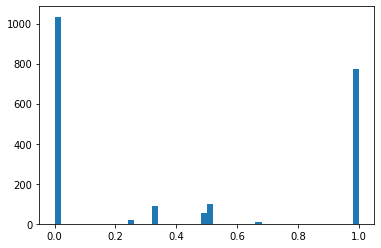

In [57]:
plt.hist(np.ndarray.flatten(rss_agg),50);

# individual circuit

(1024, 1024)


/Users/Shiye/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'energy')

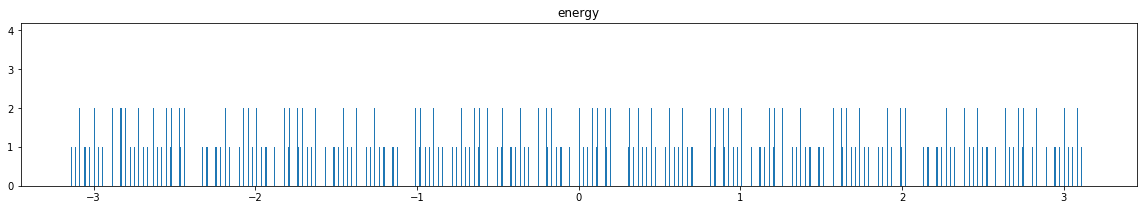

In [104]:
circuit_ind = 7
floquet_array = np.ndarray.flatten(circuits[:,circuit_ind])
uGate = unitaryGate(floquet_array=floquet_array, timesteps=1, permute=pbcBasisChange(L))
print(uGate.shape)

# print(np.allclose(np.eye(uGate.shape[0]), uGate.H * uGate))

eigvals = np.linalg.eigvals(uGate)
energy = -1j*np.log(eigvals)
# print(np.allclose(np.isreal(energy), np.ones(energy.shape)))
energy = np.sort(np.real(energy))

#--------
energy = np.round(energy,10)
#--------

delta1 = np.diff(energy[:-1])
delta2 = np.diff(energy[1:])
numerator = np.min((delta1, delta2),axis=0)
denominator = np.max((delta1, delta2),axis=0)
rs = numerator / denominator

# print(np.round(rs,10))

energy_unique, energy_unique_counts = np.unique(np.round(energy,10), return_counts=True)
rs_unique, rs_unique_counts = np.unique(np.round(rs,6), return_counts=True)

plt.figure(figsize=(20,3))
plt.bar(x=energy_unique, height=energy_unique_counts, width=np.min(np.diff(energy_unique))/3)
# plt.hist(energy,50)
plt.title('energy')

/Users/Shiye/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Shiye/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.3, 0.8, '16 nan values')

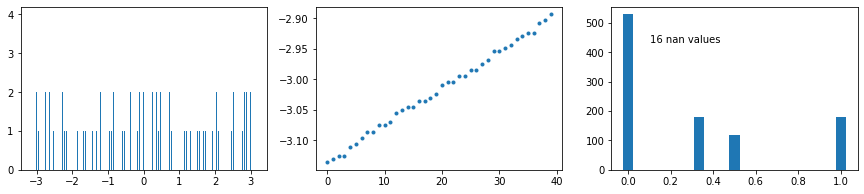

In [106]:
f = plt.figure(figsize=(15,3))
f.add_subplot(1,3,1)
plt.bar(x=energy_unique, height=energy_unique_counts, width=np.min(np.diff(energy_unique))/3)
f.add_subplot(1,3,2)
plt.plot(energy[:40], '.')
ax = f.add_subplot(1,3,3)
plt.hist(rs,50);
# plt.bar(x=rs_unique, height=rs_unique_counts, width=np.min(np.diff(rs_unique))/2)
plt.bar(x=rs_unique, height=rs_unique_counts, width=0.05)
ax.text(0.3, 0.8, str(np.sum(np.isnan(rs))) + ' nan values', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

(0, 1)

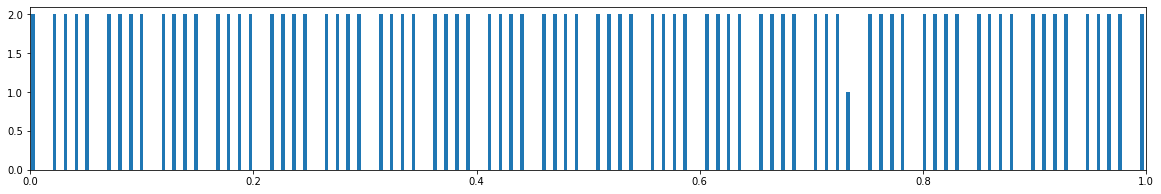

In [93]:
plt.figure(figsize=(20,3))
plt.bar(x=energy_unique, height=energy_unique_counts, width=np.min(np.diff(energy_unique))/3)
plt.xlim([0,1])

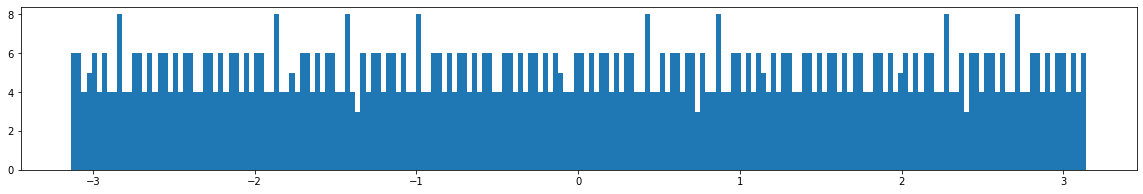

In [96]:
plt.figure(figsize=(20,3))
plt.hist(energy,200);

In [16]:
# L = 2

state = np.kron(pauliz, paulix)

output = np.round(uGate @ state @ uGate.H,0)
paulis = [identity, paulix, pauliy, pauliz]
# output = state
print(output)

for i in paulis:
    for j in paulis:
        if np.array_equal(output, np.kron(i,j)) or np.array_equal(output, -np.kron(i,j)):
            print(i)
            print(j)
            break

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 256)

In [17]:
# L = 4

state = pauliz
for i in range(L-1):
    state = np.kron(state, pauliy)
print(state.shape)

output = np.round(uGate.H @ state @ uGate,10)
paulis = [identity, paulix, pauliy, pauliz]
# output = state

for i in paulis:
    for j in paulis:
        for k in paulis:
            for l in paulis:
                if np.array_equal(output, np.kron(np.kron(np.kron(i,j),k),l)) or np.array_equal(output, -np.kron(np.kron(np.kron(i,j),k),l)):
                    print(i)
                    print(j)
                    print(k)
                    print(l)
                    break

(256, 256)
